In [10]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.sparse.linalg import svds

%matplotlib notebook

# import our datasets (MovieLens 1M Dataset)
# contains 1 million ratings from 6000 users on 4000 movies
ratings_list = [i.strip().split("::") for i in open('./datasets/ratings.dat', 'r').readlines()]
ratings_df = pd.DataFrame(ratings_list, columns=['UserID', 'MovieID', 'Rating', 'Timestamp'], dtype=int)

movies_list = [i.strip().split("::") for i in open('./datasets/movies.dat', 'r').readlines()]
movies_df = pd.DataFrame(movies_list, columns=['MovieID', 'Title', 'Genres'])

users_list = [i.strip().split("::") for i in open ('./datasets/users.dat', 'r').readlines()]

In [11]:
# contains data about users, and their movie ratings
ratings_df.head(10)

,UserID,MovieID,Rating,Timestamp
0,1,1193,5,978300760
1,1,661,3,978302109
2,1,914,3,978301968
3,1,3408,4,978300275
4,1,2355,5,978824291
5,1,1197,3,978302268
6,1,1287,5,978302039
7,1,2804,5,978300719
8,1,594,4,978302268
9,1,919,4,978301368


In [12]:
# provides data about movie titles
movies_df.head(10)

,MovieID,Title,Genres
0,1,Toy Story (1995),Animation|Children's|Comedy
1,2,Jumanji (1995),Adventure|Children's|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama
4,5,Father of the Bride Part II (1995),Comedy
5,6,Heat (1995),Action|Crime|Thriller
6,7,Sabrina (1995),Comedy|Romance
7,8,Tom and Huck (1995),Adventure|Children's
8,9,Sudden Death (1995),Action
9,10,GoldenEye (1995),Action|Adventure|Thriller


In [14]:
# from the two dataframes, create a matrix where each row=userId and each column=movieId
# since we'll be using SVD and this will act as our R, we'll name it R_df

# we'll also fill all the empty values with zeros to make our matrix dense
# a better approach will be to use a minimization function on the errors between the predicted and
# known values, but we will just use zeros for the sake of simplicity

R_df = ratings_df.pivot(index='UserID', columns='MovieID', values='Rating').fillna(0)
R_df.head(10)

MovieID,1,2,3,4,5,6,7,8,9,10,...,3943,3944,3945,3946,3947,3948,3949,3950,3951,3952
UserID,,,,,,,,,,,,,,,,,,,,,
1,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,4.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0


In [15]:
# normalize the data according to each user's mean. this is still not as good as 
# using optimization to obtain the values, but hopefully this will be better than just zeros

# when reshaping, a dimension of -1 means that the value is inferred from the length of the array
# and remaining dimensions

R = R_df.as_matrix()
user_ratings_mean = np.mean(R, axis=1)
print(user_ratings_mean)
R_demeaned = R - user_ratings_mean.reshape(-1, 1)

[0.05990286 0.12924987 0.05369671 ... 0.02050729 0.1287102  0.3291959 ]


In [16]:
# apply the SVD algorithm, which will give us three vectors
# k is the number of latent features to extract from the dataset
# k is also another variable that we can possibly optimize
# we'll also need to turn sigma into a diagonal matrix for our predictions


K_FACTOR = 50

U, sigma, Vt = svds(R_demeaned, k=K_FACTOR)
sigma = np.diag(sigma)

In [17]:
# since we de-meaned (normalized) the dataset before applying SVD, we need to add the mean back to get predictions

all_user_predicted_ratings = np.dot(np.dot(U, sigma), Vt) + user_ratings_mean.reshape(-1,1)
predictions_df = pd.DataFrame(all_user_predicted_ratings, columns=R_df.columns)

predictions_df.head(10)

MovieID,1,2,3,4,5,6,7,8,9,10,...,3943,3944,3945,3946,3947,3948,3949,3950,3951,3952
0,4.288861,0.143055,-0.195080,-0.018843,0.012232,-0.176604,-0.074120,0.141358,-0.059553,-0.195950,...,0.027807,0.001640,0.026395,-0.022024,-0.085415,0.403529,0.105579,0.031912,0.050450,0.088910
1,0.744716,0.169659,0.335418,0.000758,0.022475,1.353050,0.051426,0.071258,0.161601,1.567246,...,-0.056502,-0.013733,-0.010580,0.062576,-0.016248,0.155790,-0.418737,-0.101102,-0.054098,-0.140188
2,1.818824,0.456136,0.090978,-0.043037,-0.025694,-0.158617,-0.131778,0.098977,0.030551,0.735470,...,0.040481,-0.005301,0.012832,0.029349,0.020866,0.121532,0.076205,0.012345,0.015148,-0.109956
3,0.408057,-0.072960,0.039642,0.089363,0.041950,0.237753,-0.049426,0.009467,0.045469,-0.111370,...,0.008571,-0.005425,-0.008500,-0.003417,-0.083982,0.094512,0.057557,-0.026050,0.014841,-0.034224
4,1.574272,0.021239,-0.051300,0.246884,-0.032406,1.552281,-0.199630,-0.014920,-0.060498,0.450512,...,0.110151,0.046010,0.006934,-0.015940,-0.050080,-0.052539,0.507189,0.033830,0.125706,0.199244
5,2.080954,0.200896,0.257427,0.071778,0.188707,0.141861,0.682232,0.024831,-0.028948,0.215784,...,0.038648,0.002989,0.020866,0.063753,-0.017803,0.791963,0.155650,0.017319,0.024461,0.328527
6,0.050561,0.145551,0.071439,0.030906,-0.063137,1.535804,-0.113641,0.003906,-0.036238,1.229246,...,-0.043208,0.005675,0.008339,0.061346,-0.014502,0.530467,-0.278626,-0.064967,-0.023494,0.067700
7,0.818760,0.157268,0.691568,0.335525,-0.082421,1.705631,0.234284,0.003777,0.077987,0.601926,...,-0.076979,0.012318,-0.005415,-0.096365,-0.073352,-0.003274,0.277892,-0.034586,-0.010906,-0.034938
8,3.667258,0.125559,0.025810,-0.039819,-0.083895,0.950044,0.108963,0.007310,-0.024961,-0.069152,...,0.062487,0.001016,0.024406,0.043398,-0.010220,1.497517,0.317699,0.079573,-0.001441,0.614613
9,4.516912,2.968196,1.254102,0.378729,1.123322,-0.981174,1.934979,0.292535,-0.008434,0.942800,...,-0.010326,-0.004641,0.043944,-0.084057,-0.058872,0.857068,0.218063,0.022517,-0.000597,0.029621


In [18]:
# now we'll write a function that takes as input userID and n number of recommendations, 
# and will return the top n-recommendations along with a already-rated items

NUM_REC = 10

def recommend_movies(userID, name, num_rec=NUM_REC):
    user_row_number = userID - 1 # iloc uses purely integer-location based indexing, and userID starts at 1, not 0
    
    sorted_user_predictions = predictions_df.iloc[user_row_number].sort_values(ascending=False)
    sorted_user_predictions_df = pd.DataFrame(sorted_user_predictions).reset_index()
    
    # both columns in the merge need to be the same dtype, or it can lead to errors
    # so we'll convert MovieID in movies_df to numeric
    movies_df['MovieID'] = movies_df['MovieID'].apply(pd.to_numeric)
    user_data = ratings_df[ratings_df.UserID == (userID)]
    already_rated = user_data.merge(movies_df, how='left', left_on='MovieID', right_on='MovieID').sort_values(['Rating'], ascending=False)
    print("{} has already rated {} movies.".format(name, already_rated.shape[0]))
    print("Recommending the highest {} predicted ratings for unseen movies.".format(num_rec))
    
    predictions = movies_df[~movies_df['MovieID'].isin(already_rated['MovieID'])]
    predictions = predictions.merge(sorted_user_predictions_df, how='left', left_on='MovieID', right_on='MovieID')
    predictions = predictions.rename(columns = {user_row_number:'Predictions'}).sort_values('Predictions', ascending=False)
    
    return already_rated, predictions
    

In [19]:
# visualize the output
def show_predictions(name, predictions):
    sorted_predicted_ratings = []
    sorted_titles = []

    movie_rank = 1
    for idx, row in predictions[:NUM_REC].iterrows():
        sorted_predicted_ratings.append(row['Predictions'])
        sorted_titles.append("{}\t[{}]\t{}".format(movie_rank, round(row['Predictions'], 3), row['Title']))
        movie_rank += 1

    plt.figure()
    plt.bar(range(10), sorted_predicted_ratings, width=0.35, align='center', color='#8ACA9B', edgecolor='black', tick_label=range(1,11))
    plt.title("Top {} Predicted Recommendations for {}".format(NUM_REC, name))
    plt.xlabel("Movie")
    plt.ylabel("Predicted Rating")
    plt.ylim(ymax=sorted_predicted_ratings[0] * 1.2)
    plt.show()
    
    for title in sorted_titles:
        print(title)

In [20]:
# 837: Nancy
already_rated, predictions = recommend_movies(837, "Nancy")
already_rated.head(10)

Nancy has already rated 69 movies.
Recommending the highest 10 predicted ratings for unseen movies.


,UserID,MovieID,Rating,Timestamp,Title,Genres
36,837,858,5,975360036,"Godfather, The (1972)",Action|Crime|Drama
35,837,1387,5,975360036,Jaws (1975),Action|Horror
65,837,2028,5,975360089,Saving Private Ryan (1998),Action|Drama|War
63,837,1221,5,975360036,"Godfather: Part II, The (1974)",Action|Crime|Drama
11,837,913,5,975359921,"Maltese Falcon, The (1941)",Film-Noir|Mystery
20,837,3417,5,975360893,"Crimson Pirate, The (1952)",Adventure|Comedy|Sci-Fi
34,837,2186,4,975359955,Strangers on a Train (1951),Film-Noir|Thriller
55,837,2791,4,975360893,Airplane! (1980),Comedy
31,837,1188,4,975360920,Strictly Ballroom (1992),Comedy|Romance
28,837,1304,4,975360058,Butch Cassidy and the Sundance Kid (1969),Action|Comedy|Western


<IPython.core.display.Javascript object>


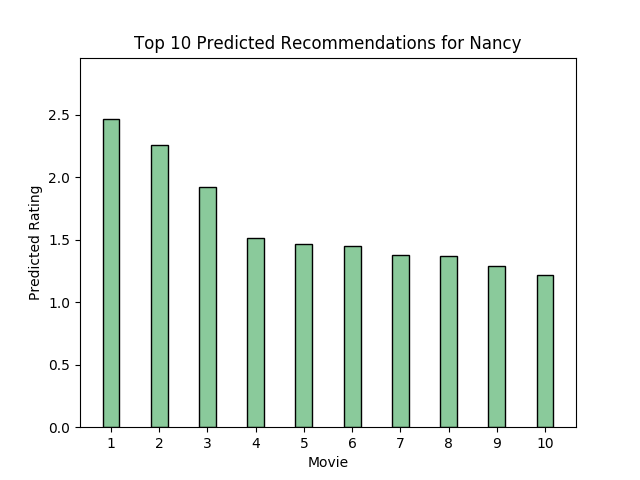

1	[2.463]	Schindler's List (1993)
2	[2.259]	French Connection, The (1971)
3	[1.918]	Fargo (1996)
4	[1.515]	Big Sleep, The (1946)
5	[1.467]	Untouchables, The (1987)
6	[1.448]	Annie Hall (1977)
7	[1.378]	Glory (1989)
8	[1.37]	Sunset Blvd. (a.k.a. Sunset Boulevard) (1950)
9	[1.293]	Rocky (1976)
10	[1.217]	Silence of the Lambs, The (1991)


In [21]:
show_predictions("Nancy", predictions)

In [22]:
# 342: Billy
already_rated, predictions = recommend_movies(342, "Billy")
already_rated.head(10)

Billy has already rated 123 movies.
Recommending the highest 10 predicted ratings for unseen movies.


,UserID,MovieID,Rating,Timestamp,Title,Genres
61,342,1909,5,976339549,"X-Files: Fight the Future, The (1998)",Mystery|Sci-Fi|Thriller
18,342,1517,5,976337936,Austin Powers: International Man of Mystery (1...,Comedy
83,342,1954,5,976338156,Rocky (1976),Action|Drama
80,342,11,5,976339126,"American President, The (1995)",Comedy|Drama|Romance
79,342,260,5,976337885,Star Wars: Episode IV - A New Hope (1977),Action|Adventure|Fantasy|Sci-Fi
76,342,318,5,976337823,"Shawshank Redemption, The (1994)",Drama
94,342,2918,5,976338374,Ferris Bueller's Day Off (1986),Comedy
67,342,2571,5,976337868,"Matrix, The (1999)",Action|Sci-Fi|Thriller
54,342,2396,5,976338314,Shakespeare in Love (1998),Comedy|Romance
102,342,50,5,976337849,"Usual Suspects, The (1995)",Crime|Thriller


<IPython.core.display.Javascript object>


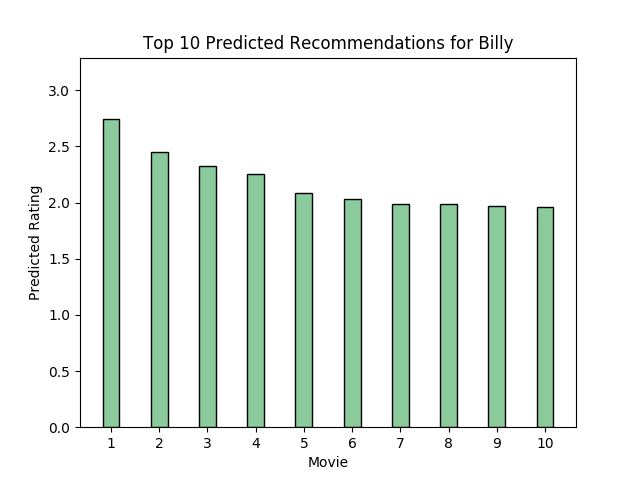

1	[2.743]	Toy Story (1995)
2	[2.449]	Fugitive, The (1993)
3	[2.324]	Dances with Wolves (1990)
4	[2.258]	Clerks (1994)
5	[2.083]	Hunt for Red October, The (1990)
6	[2.034]	Silence of the Lambs, The (1991)
7	[1.992]	Galaxy Quest (1999)
8	[1.985]	Raiders of the Lost Ark (1981)
9	[1.971]	Sneakers (1992)
10	[1.963]	Indiana Jones and the Last Crusade (1989)


In [23]:
show_predictions("Billy", predictions)

In [18]:
# 22: Carl
already_rated, predictions = recommend_movies(22, "Carl")
already_rated.head(10)

Carl has already rated 297 movies.
Recommending the highest 10 predicted ratings for unseen movies.


,UserID,MovieID,Rating,Timestamp,Title,Genres
167,22,3578,5,978134462,Gladiator (2000),Action|Drama
159,22,1394,5,978134744,Raising Arizona (1987),Comedy
261,22,1225,5,978135474,Amadeus (1984),Drama
183,22,2858,5,978134744,American Beauty (1999),Comedy|Drama
71,22,318,5,978135389,"Shawshank Redemption, The (1994)",Drama
116,22,771,5,978134623,"Vie est belle, La (Life is Rosey) (1987)",Comedy|Drama
220,22,608,5,978135545,Fargo (1996),Crime|Drama|Thriller
58,22,671,5,978134995,Mystery Science Theater 3000: The Movie (1996),Comedy|Sci-Fi
131,22,2324,5,978134977,Life Is Beautiful (La Vita � bella) (1997),Comedy|Drama
14,22,3868,5,978137282,"Naked Gun: From the Files of Police Squad!, Th...",Comedy


<IPython.core.display.Javascript object>


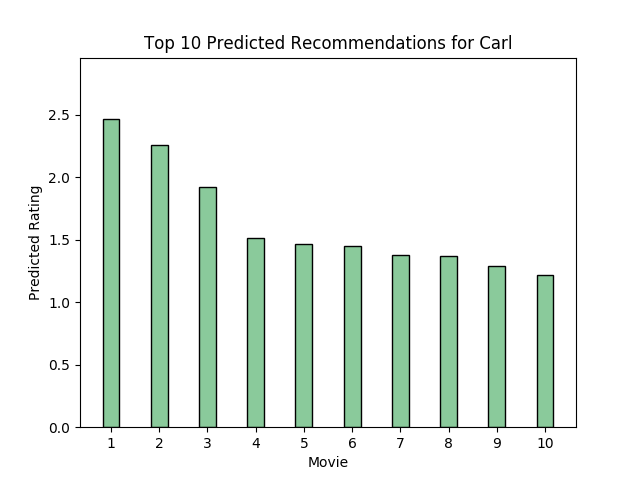

1	[2.463]	Schindler's List (1993)
2	[2.259]	French Connection, The (1971)
3	[1.918]	Fargo (1996)
4	[1.515]	Big Sleep, The (1946)
5	[1.467]	Untouchables, The (1987)
6	[1.448]	Annie Hall (1977)
7	[1.378]	Glory (1989)
8	[1.37]	Sunset Blvd. (a.k.a. Sunset Boulevard) (1950)
9	[1.293]	Rocky (1976)
10	[1.217]	Silence of the Lambs, The (1991)


In [40]:
show_predictions("Carl", predictions)